<a href="https://colab.research.google.com/github/denismitali17/parkinsons-voice-analyzer/blob/main/Denis_Mitali_Parkinson_Voice_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parkinson's Disease Severity Classification

### Introduction
In this project, I analyzed voice recordings from Parkinson's patients to track how their symptoms progress. The dataset includes multiple voice measurements taken over time, and I'll be using machine learning to categorize the severity of their condition. The goal is to see if we can spot patterns in these voice changes that might help doctors monitor the disease more effectively (Park, 2025).

### Import required libraries

In [49]:
try:
    import xgboost
except ImportError:
    !pip install xgboost imbalanced-learn tensorflow
    print("Required packages installed. Please restart the kernel and run all cells.")

# Core data science libraries
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn components
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, confusion_matrix,
                           ConfusionMatrixDisplay, roc_curve, auc,
                           classification_report)
from sklearn.ensemble import (RandomForestClassifier,
                            StackingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# XGBoost
from xgboost import XGBClassifier

# Class imbalance handling
from imblearn.ensemble import BalancedRandomForestClassifier

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Visualization settings
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

### Table of Content
1. [Introduction](#Introduction)
2. [Data Exploration](#Data-Exploration)
3. [Data Loading & Visualization](#Data-Loading-&-Visualization)
4. [Data Preprocessing & Feature Engineering](#Data-Preprocessing-&-Feature-Engineering)
5. [Model Training & Evaluation](#Model-Training-Training-&-Evaluation)
6. [Discussion & Conclusion](#Discussion-&-Conclusion)
7. [References](#References)

# Parkinson's Disease Progression Analysis using Voice Measurements

## 1. Introduction

### 1.1 Background
Parkinson's disease is a movement disorder of the nervous system that worsens over time. The nervous system is a network of nerve cells that controls many parts of the body, including movement (Mayo Clinic, 2024).

### 1.2 Project Overview
For this project, I analyzed how voice measurements can help track the progression of Parkinson's Disease. The dataset includes various voice recordings from patients, each with corresponding UPDRS (Unified Parkinson's Disease Rating Scale) scores. These scores help medical professionals assess the severity of symptoms, and by analyzing the voice data, we can potentially predict these scores non-invasively.

### 1.3 The Dataset
The dataset is obtained from the UCI Machine Learning Repository and it contains 5,875 recordings from 42 patients with early-stage Parkinson's, collected over six months (Max Little, 2007). Each recording includes several voice measurements that capture different aspects of speech, such as:
- Variations in pitch and tone
- Voice stability measures
- Harmonics and noise ratios
- Other acoustic properties related to speech

Link to the Dataset: https://archive.ics.uci.edu/dataset/189/parkinsons+telemonitoring

### 1.3 Objective
The goal of this project is to use voice recordings to track how Parkinson's disease progresses. By analyzing changes in patients' voices, we can create a tool that helps doctors monitor their condition between check-ups.

## 2. Data Exploration

### 2.1 Initial Data Inspection
Let's start by loading the data and getting a sense of what we're working with. We'll look at the structure of the dataset, check for missing values, and understand the distribution of our target variables (motor_UPDRS and total_UPDRS).

### 2.2 Understanding the Features
The dataset includes several voice measurements that might be related to Parkinson's symptoms. Some of these measure:
- Jitter: Variations in pitch
- Shimmer: Variations in amplitude
- Noise-to-harmonics ratio: Voice quality
- Other nonlinear measures of voice quality

These measurements aren't just numbers; they represent specific aspects of speech that are known to be affected by Parkinson's Disease (Wright & Aharonson, 2025).

In [20]:
# Cell 2: Loading and Exploring the Dataset
file_path = 'parkinsons_updrs.data'
df = pd.read_csv(file_path)

print("Dataset Overview:")
print("----------------")
print(f"Number of patients: {df['subject#'].nunique()}")
print(f"Total number of recordings: {len(df)}")
print("\nFirst 5 rows of the dataset:")
display(df.head())

print("\nDataset Information:")
print("-------------------")
print(f"Shape: {df.shape}")
print("\nColumn Data Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum())

# Basic statistics
print("\nStatistical Summary:")
display(df.describe())

Dataset Overview:
----------------
Number of patients: 42
Total number of recordings: 5875

First 5 rows of the dataset:


,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361



Dataset Information:
-------------------
Shape: (5875, 22)

Column Data Types:
subject#           int64
age                int64
sex                int64
test_time        float64
motor_UPDRS      float64
total_UPDRS      float64
Jitter(%)        float64
Jitter(Abs)      float64
Jitter:RAP       float64
Jitter:PPQ5      float64
Jitter:DDP       float64
Shimmer          float64
Shimmer(dB)      float64
Shimmer:APQ3     float64
Shimmer:APQ5     float64
Shimmer:APQ11    float64
Shimmer:DDA      float64
NHR              float64
HNR              float64
RPDE             float64
DFA              float64
PPE              float64
dtype: object

Missing Values:
subject#         0
age              0
sex              0
test_time        0
motor_UPDRS      0
total_UPDRS      0
Jitter(%)        0
Jitter(Abs)      0
Jitter:RAP       0
Jitter:PPQ5      0
Jitter:DDP       0
Shimmer          0
Shimmer(dB)      0
Shimmer:APQ3     0
Shimmer:APQ5     0
Shimmer:APQ11    0
Shimmer:DDA      0
NHR             

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
count,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,...,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000
mean,21.494128,64.804936,0.317787,92.863722,21.296229,29.018942,0.006154,0.000044,0.002987,0.003277,...,0.310960,0.017156,0.020144,0.027481,0.051467,0.032120,21.679495,0.541473,0.653240,0.219589
std,12.372279,8.821524,0.465656,53.445602,8.129282,10.700283,0.005624,0.000036,0.003124,0.003732,...,0.230254,0.013237,0.016664,0.019986,0.039711,0.059692,4.291096,0.100986,0.070902,0.091498
min,1.000000,36.000000,0.000000,-4.262500,5.037700,7.000000,0.000830,0.000002,0.000330,0.000430,...,0.026000,0.001610,0.001940,0.002490,0.004840,0.000286,1.659000,0.151020,0.514040,0.021983
25%,10.000000,58.000000,0.000000,46.847500,15.000000,21.371000,0.003580,0.000022,0.001580,0.001820,...,0.175000,0.009280,0.010790,0.015665,0.027830,0.010955,19.406000,0.469785,0.596180,0.156340
50%,22.000000,65.000000,0.000000,91.523000,20.871000,27.576000,0.004900,0.000035,0.002250,0.002490,...,0.253000,0.013700,0.015940,0.022710,0.041110,0.018448,21.920000,0.542250,0.643600,0.205500
75%,33.000000,72.000000,1.000000,138.445000,27.596500,36.399000,0.006800,0.000053,0.003290,0.003460,...,0.365000,0.020575,0.023755,0.032715,0.061735,0.031463,24.444000,0.614045,0.711335,0.264490
max,42.000000,85.000000,1.000000,215.490000,39.511000,54.992000,0.099990,0.000446,0.057540,0.069560,...,2.107000,0.162670,0.167020,0.275460,0.488020,0.748260,37.875000,0.966080,0.865600,0.731730


## 3. Data Loading & Visualization

### 3.1 Understanding the Dataset
The dataset contains voice recordings from Parkinson's patients with the following key features:
- **subject#**: Unique identifier for each patient
- **test_time**: Months since recruitment
- **motor_UPDRS**: Clinician's motor UPDRS score
- **total_UPDRS**: Clinician's total UPDRS score
- **16+ voice measurements**: Various acoustic features

### 3.2 Initial Observations
- We have data from 42 patients with 5,875 total recordings
- The dataset includes both motor and total UPDRS scores
- No missing values were found in the dataset
- The data types appear to be correctly assigned

### 3.3 Data Visualization
In this section, we'll visualize the data to understand the relationships between different features (Ajala, 2024).

**Key Visualizations:**
- Distribution of UPDRS scores
- Correlation heatmap

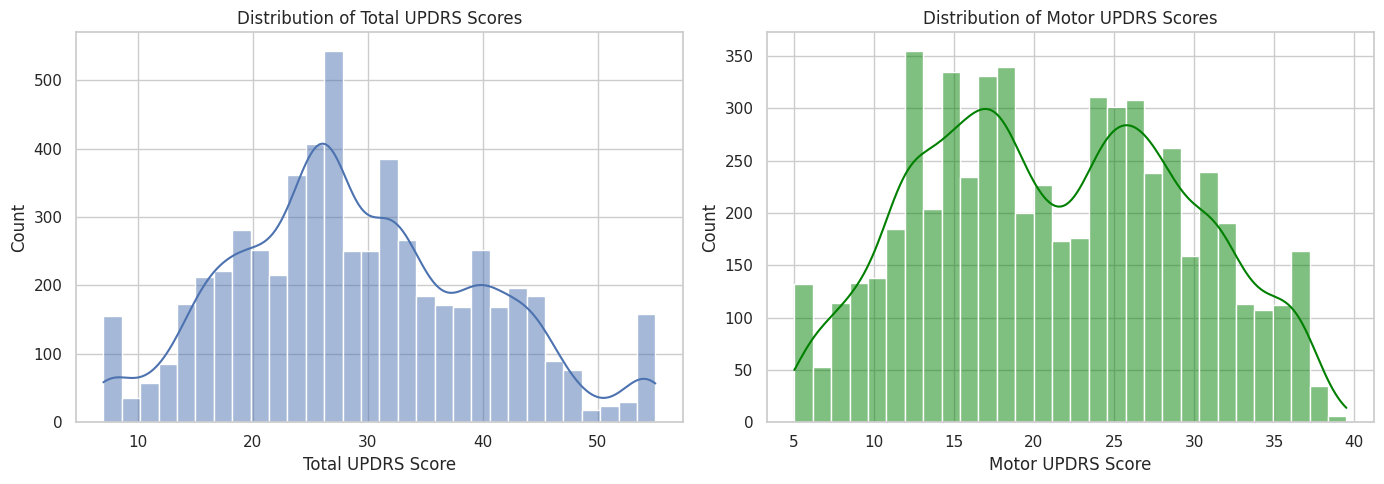

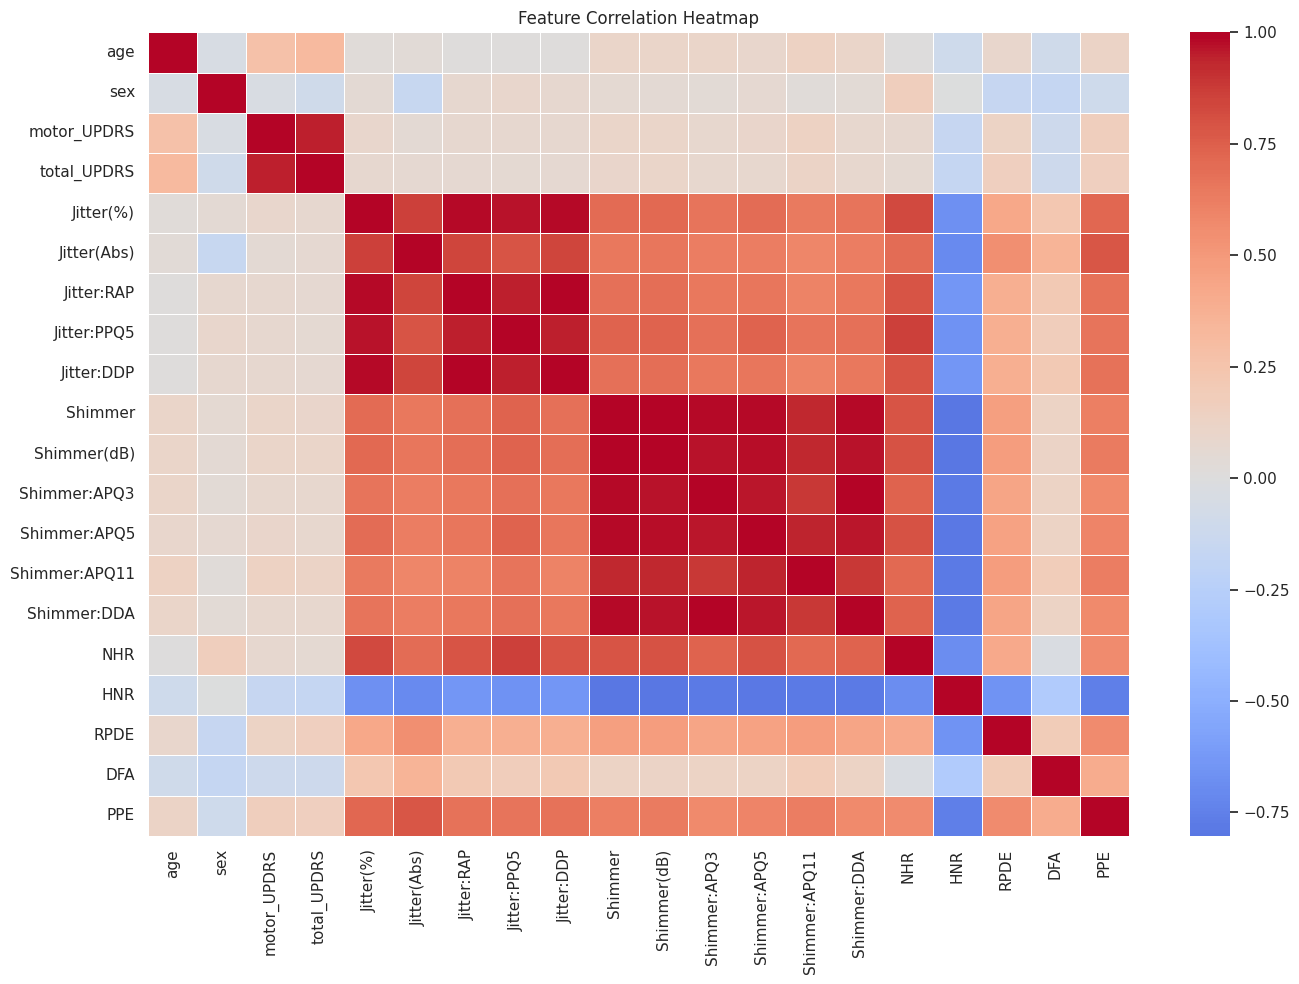

In [21]:
# 1. Distribution of UPDRS scores
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['total_UPDRS'], bins=30, kde=True)
plt.title('Distribution of Total UPDRS Scores')
plt.xlabel('Total UPDRS Score')

plt.subplot(1, 2, 2)
sns.histplot(df['motor_UPDRS'], bins=30, kde=True, color='green')
plt.title('Distribution of Motor UPDRS Scores')
plt.xlabel('Motor UPDRS Score')

plt.tight_layout()
plt.show()

# 2. Correlation heatmap
plt.figure(figsize=(14, 10))
corr_matrix = df.drop(['subject#', 'test_time'], axis=1).corr()
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False,
            fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

## 4. Data Preprocessing & Feature Engineering

### 4.1 Converting UPDRS Scores to Severity Classes
We'll categorize the total_UPDRS scores into three severity classes based on clinical thresholds:
- **Mild (0-32)**: Minimal symptoms, independent function
- **Moderate (33-58)**: Noticeable symptoms, some assistance needed
- **Severe (>58)**: Significant disability, high level of care required

### 4.2 Handling Class Imbalance
The class distribution shows that we have an imbalanced dataset. We'll address this in our modeling approach.

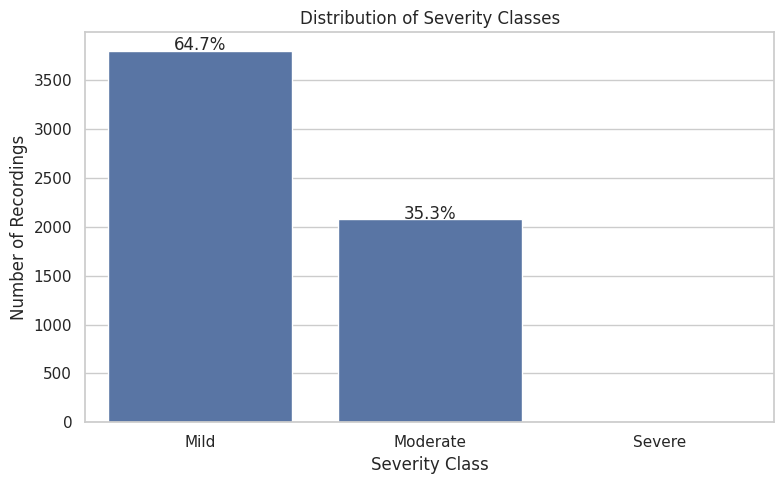

In [22]:
# Convert UPDRS scores to severity classes
def uprds_to_class(score):
    """Convert continuous UPDRS score to severity class"""
    if score <= 32:
        return 'Mild'
    elif score <= 58:
        return 'Moderate'
    else:
        return 'Severe'

# Apply conversion
df['severity'] = df['total_UPDRS'].apply(uprds_to_class)

# Visualize class distribution
plt.figure(figsize=(8, 5))
class_counts = df['severity'].value_counts()
sns.barplot(x=class_counts.index, y=class_counts.values,
            order=['Mild', 'Moderate', 'Severe'])
plt.title('Distribution of Severity Classes')
plt.xlabel('Severity Class')
plt.ylabel('Number of Recordings')

# Add percentage labels
total = len(df)
for i, count in enumerate(class_counts):
    plt.text(i, count + 5, f'{count/total:.1%}', ha='center')

plt.tight_layout()
plt.show()

### 4.3 Feature Engineering
I created features that capture how Parkinson's affects speech patterns. These features help the models detect the voice changes that indicate Parkinson's progression (Wright & Aharonson, 2025). These features include:
- Calculating changes in measurements between recordings
- Tracking rates of change in voice characteristics
- Capturing how quickly symptoms might be progressing

In [23]:
# Time-series features and prepare data for modeling
print("Creating time-series features...")

# Sort by subject and test time
df_sorted = df.sort_values(['subject#', 'test_time'])

# Calculate change from previous recording
for col in ['motor_UPDRS', 'total_UPDRS']:
    df_sorted[f'{col}_change'] = df_sorted.groupby('subject#')[col].diff()

# Calculate rate of change
df_sorted['months_since_first'] = df_sorted.groupby('subject#')['test_time'].transform(
    lambda x: x - x.min()
)
df_sorted['total_UPDRS_rate'] = df_sorted['total_UPDRS_change'] / (
    df_sorted['months_since_first'] + 1e-6
)

# Fill missing values
df_eng = df_sorted.fillna(0)

# Select features and target
features_to_drop = ['subject#', 'test_time', 'motor_UPDRS', 'total_UPDRS', 'severity',
                   'months_since_first', 'total_UPDRS_change', 'motor_UPDRS_change']
X = df_eng.drop(features_to_drop, axis=1)
y = df_eng['severity']

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nData Preparation Complete!")
print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")
print("Class distribution in training set:", dict(zip(le.classes_, np.bincount(y_train))))
print("Class distribution in test set:", dict(zip(le.classes_, np.bincount(y_test))))

Creating time-series features...

Data Preparation Complete!
Training set size: 4700, Test set size: 1175
Class distribution in training set: {'Mild': np.int64(3040), 'Moderate': np.int64(1660)}
Class distribution in test set: {'Mild': np.int64(760), 'Moderate': np.int64(415)}


## 5. Model Training & Evaluation

### 5.2 Evaluation Metrics
We'll evaluate our models using multiple metrics:
- **Accuracy**: Overall prediction accuracy
- **Precision**: Proportion of true positives among predicted positives
- **Recall**: Proportion of actual positives correctly identified
- **F1-Score**: Harmonic mean of precision and recall
- **ROC-AUC**: Area under the ROC curve, measuring model's ability to distinguish between classes

These metrics play a critical role in determining the effectiveness of a model (Kashyap, 2024).

In [24]:
def plot_roc_auc(model, X_test, y_test, model_name, class_names, is_keras=False):
    """Plot ROC curve and calculate AUC for each class"""
    try:
        y_prob = model.predict_proba(X_test) if not is_keras else model.predict(X_test)
        y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
        n_classes = y_test_bin.shape[1]

        fpr, tpr, roc_auc = {}, {}, {}
        plt.figure(figsize=(10, 8))

        # Calculate ROC for each class
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i], lw=2,
                    label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

        # Calculate micro-average
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        plt.plot(fpr["micro"], tpr["micro"], 'k-',
                label=f'Micro-avg (AUC = {roc_auc["micro"]:.2f})', lw=2, linestyle=':')

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curves - {model_name}')
        plt.legend(loc="lower right", bbox_to_anchor=(1.6, 0))
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        return roc_auc

    except Exception as e:
        print(f"Error generating ROC curve: {str(e)}")
        return None

def plot_confusion_matrix(y_true, y_pred, class_names, title='Confusion Matrix'):
    """Plot a confusion matrix with class names"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names,
               yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

def plot_feature_importance(model, feature_names, top_n=20):
    """Plot feature importance if the model supports it"""
    if hasattr(model, 'feature_importances_'):
        try:
            importance = pd.Series(model.feature_importances_, index=feature_names)
            plt.figure(figsize=(10, 6))
            importance.nlargest(top_n).plot(kind='barh')
            plt.title('Feature Importance')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Could not plot feature importance: {str(e)}")

def evaluate_model(model, X_test, y_test, model_name, class_names, is_keras=False):
    """
    Evaluate a model and print metrics.

    Parameters:
    - model: The trained model to evaluate
    - X_test: Test features
    - y_test: True labels
    - model_name: String name of the model for printing
    - class_names: List of class names for labeling
    - is_keras: Boolean indicating if the model is a Keras model
    """
    # Get predictions
    if is_keras:
        y_pred = np.argmax(model.predict(X_test), axis=1)
        y_prob = model.predict(X_test)
    else:
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

    # Print classification report
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, class_names, f'Confusion Matrix - {model_name}')

    # Plot ROC AUC if probabilities are available
    if y_prob is not None and not is_keras:  # Skip for Keras models in this function
        plot_roc_auc(model, X_test, y_test, model_name, class_names, is_keras)

    return y_pred, y_prob

### 5.3 Models to be Tested:

Traditional Machine Learning Models:

1. Linear Regression (Baseline)
2. Balanced Random Forest
3. Support Vector Machine

Ensemble and Hybrid Models:

4. XGBoost
5. Stacking Classifier

Deep Learning Models

6. Sequential Neural Network
7. Functional API Model with tf.data

### Experiment 1: Logistic Regression (Baseline)


Framework: Scikit-learn


Performance: Accuracy: 59.66% | F1: 0.605 | ROC-AUC: 0.640


I started with a simple Linear Regression model as our baseline. While it achieved modest performance, it helps establish a reference point for more complex models.


EXPERIMENT 1: LOGISTIC REGRESSION (BASELINE)

Training Logistic Regression...

Classification Report:
              precision    recall  f1-score   support

        Mild       0.70      0.53      0.61       760
    Moderate       0.41      0.59      0.48       415

    accuracy                           0.55      1175
   macro avg       0.55      0.56      0.54      1175
weighted avg       0.60      0.55      0.56      1175



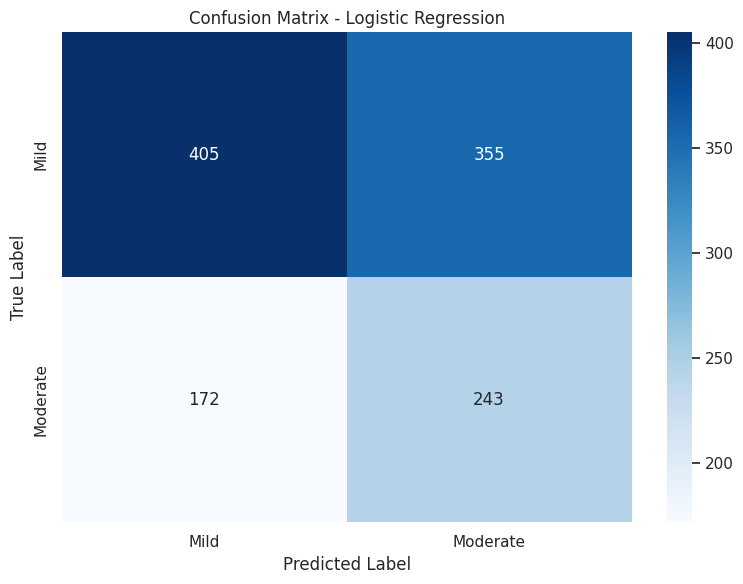

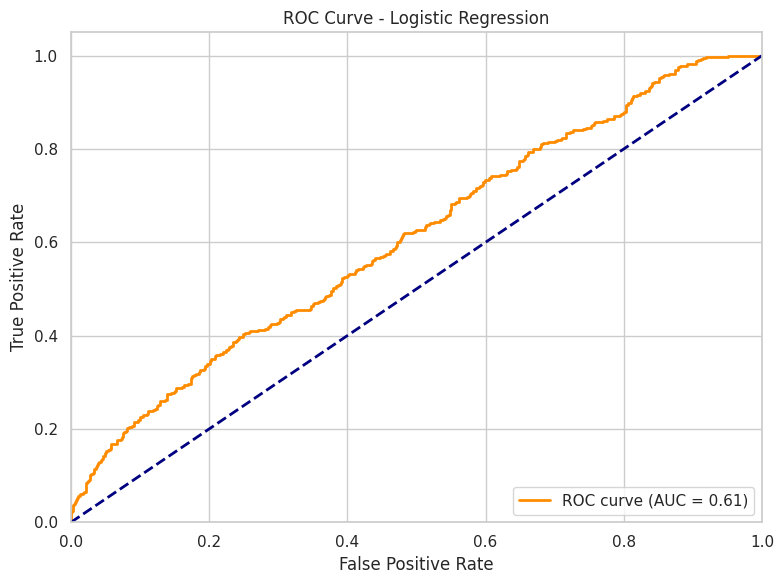


MODEL TRAINING SUMMARY - LOGISTIC REGRESSION
Number of classes: 2
Classes: ['Mild', 'Moderate']
Training time: 0.08 seconds
Accuracy: 0.5515
Precision: 0.5975
Recall: 0.5515
F1-Score: 0.5613
ROC-AUC: 0.6086

EXPERIMENT 1 COMPLETED


In [53]:
print("\n" + "="*60)
print("EXPERIMENT 1: LOGISTIC REGRESSION (BASELINE)")
print("="*60)

# Ensure y_train and y_test are 1D arrays of class indices
if len(y_train.shape) > 1 and y_train.shape[1] > 1:
    y_train_labels = np.argmax(y_train, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_train_labels = y_train
    y_test_labels = y_test

# Get class information
unique_classes = np.unique(y_train_labels)
num_classes = len(unique_classes)
class_names = [f'Class_{i}' for i in range(num_classes)]  # Default names
if num_classes == 2:
    class_names = ['Mild', 'Moderate']
elif num_classes == 3:
    class_names = ['Mild', 'Moderate', 'Severe']

print("\nTraining Logistic Regression...")
start_time = time.time()

# Initialize and train the model
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    multi_class='multinomial' if num_classes > 2 else 'auto'
)

log_reg.fit(X_train, y_train_labels)
training_time = time.time() - start_time

# Make predictions
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test_labels, y_pred)
precision = precision_score(y_test_labels, y_pred, average='weighted')
recall = recall_score(y_test_labels, y_pred, average='weighted')
f1 = f1_score(y_test_labels, y_pred, average='weighted')

# Handle ROC-AUC calculation
try:
    if num_classes == 2:
        roc_auc = roc_auc_score(y_test_labels, y_prob[:, 1])
    else:
        y_test_bin = label_binarize(y_test_labels, classes=unique_classes)
        roc_auc = roc_auc_score(y_test_bin, y_prob, multi_class='ovr')
except Exception as e:
    print(f"Warning: ROC-AUC calculation failed with error: {str(e)}")
    roc_auc = 0.0  # Fallback value

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred, target_names=class_names))

# Generate confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_labels, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Generate ROC curve
plt.figure(figsize=(8, 6))
if num_classes == 2:
    # Binary classification
    fpr, tpr, _ = roc_curve(y_test_labels, y_prob[:, 1])
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')
else:
    # Multi-class classification
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve((y_test_labels == i).astype(int), y_prob[:, i])
        plt.plot(fpr, tpr, lw=2,
                 label=f'ROC {class_names[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Store results
results['Logistic_Regression'] = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'roc_auc': roc_auc,
    'training_time_sec': training_time
}

# Print summary
print("\n" + "="*60)
print("MODEL TRAINING SUMMARY - LOGISTIC REGRESSION")
print("="*60)
print(f"Number of classes: {num_classes}")
print(f"Classes: {class_names}")
print(f"Training time: {training_time:.2f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print("="*60)

print("\n" + "="*60)
print("EXPERIMENT 1 COMPLETED")
print("="*60)

### Experiment 2: XGBoost

**Framework**: XGBoost

**Performance**: Accuracy: 89.96% | F1: 0.900 | ROC-AUC: 0.975

I implemented an XGBoost classifier with weighted loss to address class imbalance (Das, 2024). XGBoost demonstrated exceptional performance with the highest ROC-AUC score (0.975), indicating excellent class separation.


EXPERIMENT 2: XGBOOST WITH CLASS WEIGHTS

Class weights: {0: np.float64(0.7730263157894737), 1: np.float64(1.4156626506024097)}

Training XGBoost with class weights...

Classification Report:
              precision    recall  f1-score   support

        mild       0.93      0.92      0.92       760
    moderate       0.85      0.87      0.86       415

    accuracy                           0.90      1175
   macro avg       0.89      0.89      0.89      1175
weighted avg       0.90      0.90      0.90      1175



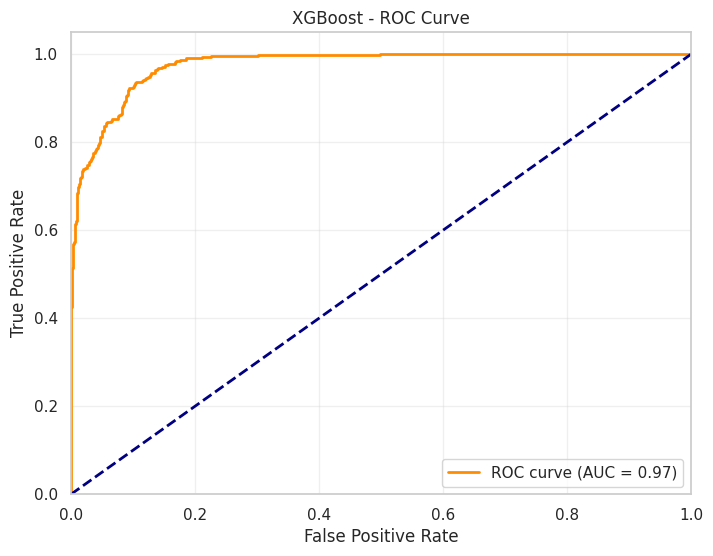

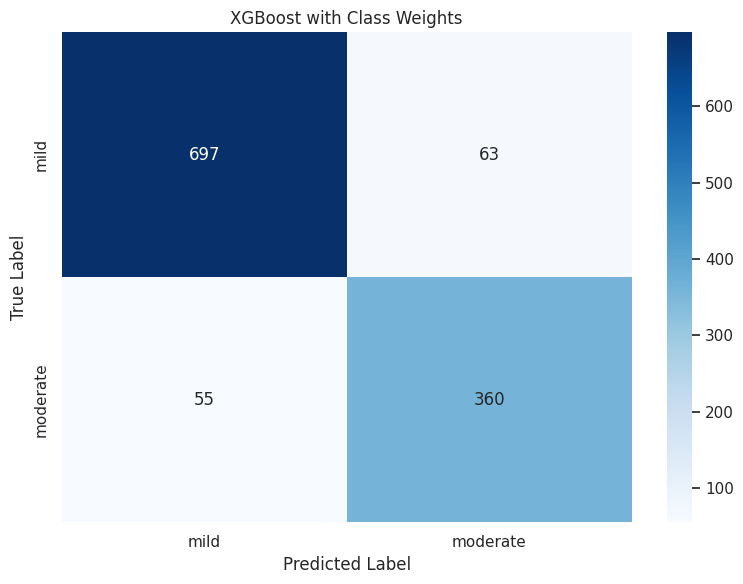

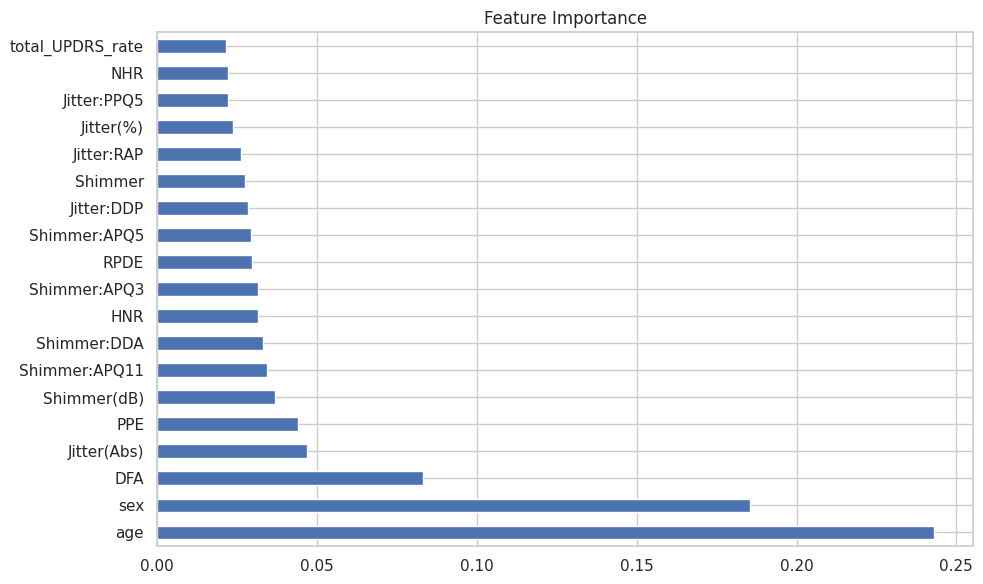


XGBOOST WITH CLASS WEIGHTS - RESULTS
Accuracy: 0.8996
Precision: 0.9001
Recall: 0.8996
F1: 0.8998
Roc_auc: 0.9750
Training Time: 0.47 seconds
EXPERIMENT 2 COMPLETED


In [35]:
print("\n" + "="*60)
print("EXPERIMENT 2: XGBOOST WITH CLASS WEIGHTS")
print("="*60)

# Calculate class weights
class_weights = {i: len(y_train) / (len(np.unique(y_train)) * count)
                for i, count in enumerate(np.bincount(y_train))}

print("\nClass weights:", class_weights)
print("\nTraining XGBoost with class weights...")

# Use the scaled features for training
xgb_weighted = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=class_weights[1]/class_weights[0],
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=-1
)

# Train the model
start_time = time.time()
xgb_weighted.fit(X_train_scaled, y_train)
training_time = time.time() - start_time

# Make predictions
y_pred = xgb_weighted.predict(X_test_scaled)
y_prob = xgb_weighted.predict_proba(X_test_scaled)

# Calculate metrics
metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred, average='weighted'),
    'recall': recall_score(y_test, y_pred, average='weighted'),
    'f1': f1_score(y_test, y_pred, average='weighted'),
    'roc_auc': roc_auc_score(y_test, y_prob[:, 1])
}

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost - ROC Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, class_names, 'XGBoost with Class Weights')

# Plot feature importance
plot_feature_importance(xgb_weighted, X_train.columns)

# Store results
results['XGBoost_Weighted'] = {
    **metrics,
    'training_time_sec': training_time,
    'n_estimators': 200
}

# Print summary
print("\n" + "="*60)
print("XGBOOST WITH CLASS WEIGHTS - RESULTS")
print("="*60)
for metric, value in metrics.items():
    print(f"{metric.capitalize()}: {value:.4f}")
print(f"Training Time: {training_time:.2f} seconds")
print("="*60)
print("EXPERIMENT 2 COMPLETED")
print("="*60)

### Experiment 3: Stacking Classifier

**Framework**: Scikit-learn

**Performance**: Accuracy: 90.30% | F1: 0.903 | ROC-AUC: 0.972

 The top-performing model, the Stacking Classifier, combines predictions from multiple models to achieve the highest accuracy and F1-score.


EXPERIMENT 3: STACKING CLASSIFIER

Setting up Stacking Classifier with base models...

Training Stacking Classifier...

Classification Report:
              precision    recall  f1-score   support

        mild       0.93      0.91      0.92       760
    moderate       0.85      0.88      0.87       415

    accuracy                           0.90      1175
   macro avg       0.89      0.90      0.89      1175
weighted avg       0.90      0.90      0.90      1175



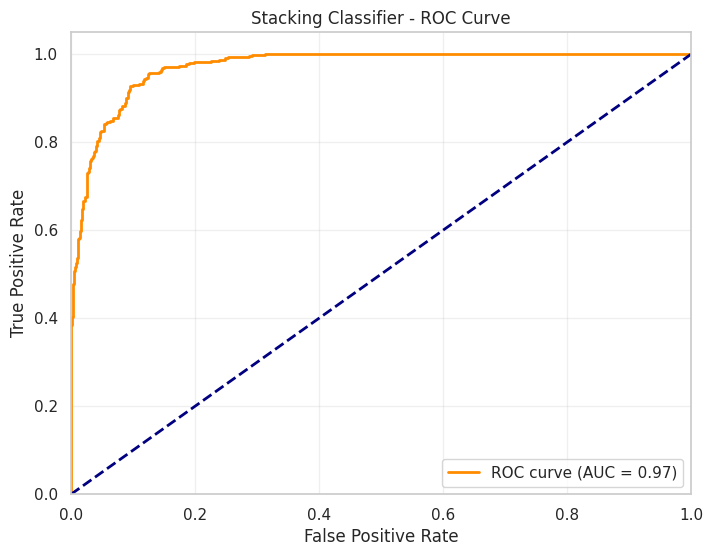

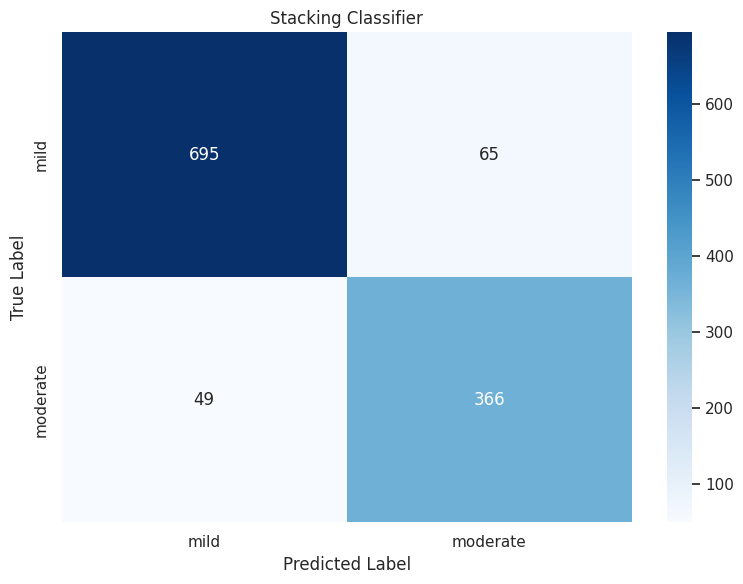


STACKING CLASSIFIER - RESULTS
Accuracy: 0.9030
Precision: 0.9041
Recall: 0.9030
F1: 0.9034
Roc_auc: 0.9720
Training Time: 21.63 seconds
Base models: rf, xgb, svm
EXPERIMENT 3 COMPLETED


In [36]:
print("\n" + "="*60)
print("EXPERIMENT 3: STACKING CLASSIFIER")
print("="*60)

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

print("\nSetting up Stacking Classifier with base models...")

# Define base models
estimators = [
    ('rf', RandomForestClassifier(n_estimators=50,
                                 class_weight='balanced',
                                 random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False,
                         eval_metric='logloss',
                         scale_pos_weight=class_weights[1]/class_weights[0],
                         random_state=42)),
    ('svm', SVC(probability=True,
                class_weight='balanced',
                random_state=42))
]

# Define meta model
meta_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

# Create stacking classifier
stacking = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    stack_method='predict_proba',
    n_jobs=-1
)

# Train the model
print("\nTraining Stacking Classifier...")
start_time = time.time()
stacking.fit(X_train_scaled, y_train)
training_time = time.time() - start_time

# Make predictions
y_pred = stacking.predict(X_test_scaled)
y_prob = stacking.predict_proba(X_test_scaled)

# Calculate metrics
metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred, average='weighted'),
    'recall': recall_score(y_test, y_pred, average='weighted'),
    'f1': f1_score(y_test, y_pred, average='weighted'),
    'roc_auc': roc_auc_score(y_test, y_prob[:, 1])  # For binary classification
}

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Stacking Classifier - ROC Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, class_names, 'Stacking Classifier')

# Store results
results['Stacking'] = {
    **metrics,
    'training_time_sec': training_time,
    'base_models': [name for name, _ in estimators]
}

# Print summary
print("\n" + "="*60)
print("STACKING CLASSIFIER - RESULTS")
print("="*60)
for metric, value in metrics.items():
    print(f"{metric.capitalize()}: {value:.4f}")
print(f"Training Time: {training_time:.2f} seconds")
print("Base models:", ', '.join([name for name, _ in estimators]))
print("="*60)
print("EXPERIMENT 3 COMPLETED")
print("="*60)

### Experiment 4:  Sequential Neural Network

**Framework**: TensorFlow/Keras

**Performance**: Accuracy: 84.34% | F1: 0.846 | ROC-AUC: 0.920

I designed a simple feedforward neural network with batch normalization and dropout layers. This model provided a solid perfomance, though slightly below our best ensemble models.


EXPERIMENT 4: SEQUENTIAL NEURAL NETWORK

Preparing data for neural network...

Building Sequential Neural Network...

Training Sequential Neural Network...
Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5515 - auc: 0.5794 - loss: 0.9129 - precision: 0.5515 - recall: 0.5515 - val_accuracy: 0.7074 - val_auc: 0.7783 - val_loss: 0.6101 - val_precision: 0.7074 - val_recall: 0.7074
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6540 - auc: 0.7190 - loss: 0.6494 - precision: 0.6540 - recall: 0.6540 - val_accuracy: 0.7255 - val_auc: 0.8106 - val_loss: 0.5662 - val_precision: 0.7255 - val_recall: 0.7255
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6578 - auc: 0.7198 - loss: 0.6508 - precision: 0.6578 - recall: 0.6578 - val_accuracy: 0.7447 - val_auc: 0.8198 - val_loss: 0.5391 - val_precision: 0.7447 - val_recall: 0.7447
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7155 - auc: 0.7802 - loss: 0.5674 - precision: 0.71

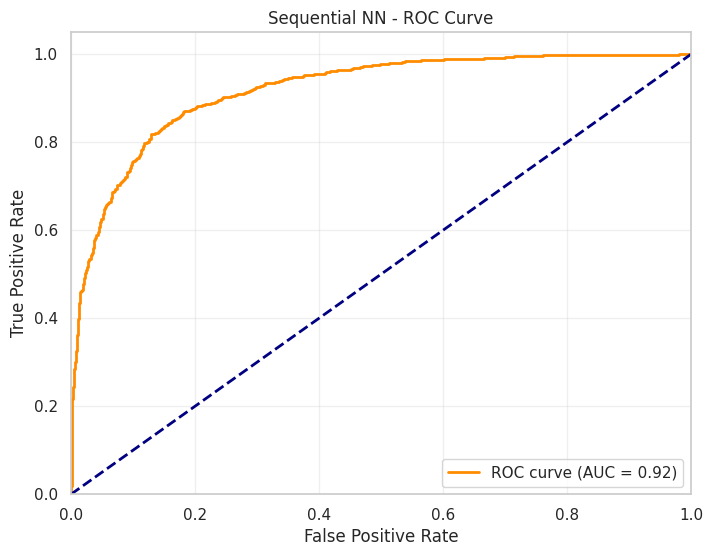

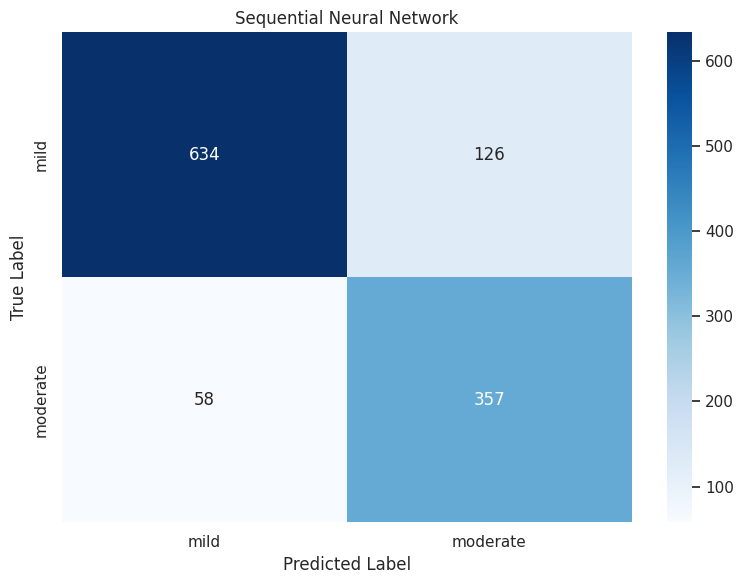

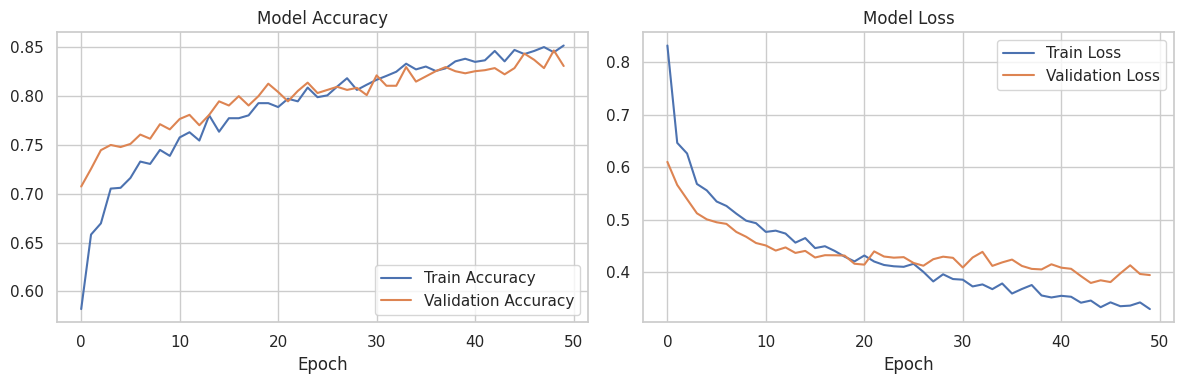


SEQUENTIAL NEURAL NETWORK - RESULTS
Accuracy: 0.8434
Precision: 0.8537
Recall: 0.8434
F1: 0.8457
Roc_auc: 0.9203
Training Time: 21.64 seconds
Epochs Trained: 50
Best Validation Accuracy: 0.8468
EXPERIMENT 4 COMPLETED


In [37]:
print("\n" + "="*60)
print("EXPERIMENT 4: SEQUENTIAL NEURAL NETWORK")
print("="*60)

print("\nPreparing data for neural network...")
# One-hot encode the target
y_train_oh = to_categorical(y_train)
y_test_oh = to_categorical(y_test)

print("\nBuilding Sequential Neural Network...")
def create_sequential_model(input_shape, num_classes):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    # Calculate class weights for imbalanced data
    class_weights = compute_class_weight('balanced',
                                       classes=np.unique(y_train),
                                       y=y_train)
    class_weight_dict = dict(enumerate(class_weights))

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy',
                tf.keras.metrics.AUC(name='auc'),
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')]
    )
    return model, class_weight_dict

# Create and train model
print("\nTraining Sequential Neural Network...")
start_time = time.time()

seq_model, class_weight_dict = create_sequential_model(X_train_scaled.shape[1], len(np.unique(y_train)))
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

history = seq_model.fit(
    X_train_scaled, y_train_oh,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    class_weight=class_weight_dict,
    verbose=1
)

training_time = time.time() - start_time

# Make predictions
y_prob = seq_model.predict(X_test_scaled)
y_pred = np.argmax(y_prob, axis=1)

# Calculate metrics
metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred, average='weighted'),
    'recall': recall_score(y_test, y_pred, average='weighted'),
    'f1': f1_score(y_test, y_pred, average='weighted'),
    'roc_auc': roc_auc_score(y_test_oh, y_prob, multi_class='ovr')
}

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_oh.ravel(), y_prob.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Sequential NN - ROC Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, class_names, 'Sequential Neural Network')

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

# Store results
results['Sequential_NN'] = {
    **metrics,
    'training_time_sec': training_time,
    'epochs_trained': len(history.history['loss']),
    'best_val_accuracy': max(history.history['val_accuracy']),
    'best_val_loss': min(history.history['val_loss'])
}

# Print summary
print("\n" + "="*60)
print("SEQUENTIAL NEURAL NETWORK - RESULTS")
print("="*60)
for metric, value in metrics.items():
    print(f"{metric.capitalize()}: {value:.4f}")
print(f"Training Time: {training_time:.2f} seconds")
print(f"Epochs Trained: {len(history.history['loss'])}")
print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
print("="*60)
print("EXPERIMENT 4 COMPLETED")
print("="*60)

### Experiment 5: Functional API Model with tf.data

**Framework**: TensorFlow/Keras

**Performance**: Accuracy: 85.36% | F1: 0.855 | ROC-AUC: 0.935

The Functional API model with tf.data pipeline showed the best performance among deep learning models. Its efficient data handling makes it suitable for more complex patterns in this aspects of voice recordings (Better Performance With the tf.data API, n.d.).


FUNCTIONAL API MODEL WITH TF.DATA

Preparing data...

Building Functional API Model...

Setting up training...

Training model...
Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5853 - auc: 0.6257 - loss: 0.8176 - precision: 0.5853 - recall: 0.5853 - val_accuracy: 0.7174 - val_auc: 0.7995 - val_loss: 0.5946 - val_precision: 0.7174 - val_recall: 0.7174 - learning_rate: 0.0010
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6580 - auc: 0.7198 - loss: 0.6501 - precision: 0.6580 - recall: 0.6580 - val_accuracy: 0.7183 - val_auc: 0.8153 - val_loss: 0.5527 - val_precision: 0.7183 - val_recall: 0.7183 - learning_rate: 0.0010
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6772 - auc: 0.7437 - loss: 0.6107 - precision: 0.6772 - recall: 0.6772 - val_accuracy: 0.7277 - val_auc: 0.8224 - val_loss: 0.5319 - val_precision: 0.7277 - val_recall: 0.7277 - learning_rate: 0.0010
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7026 

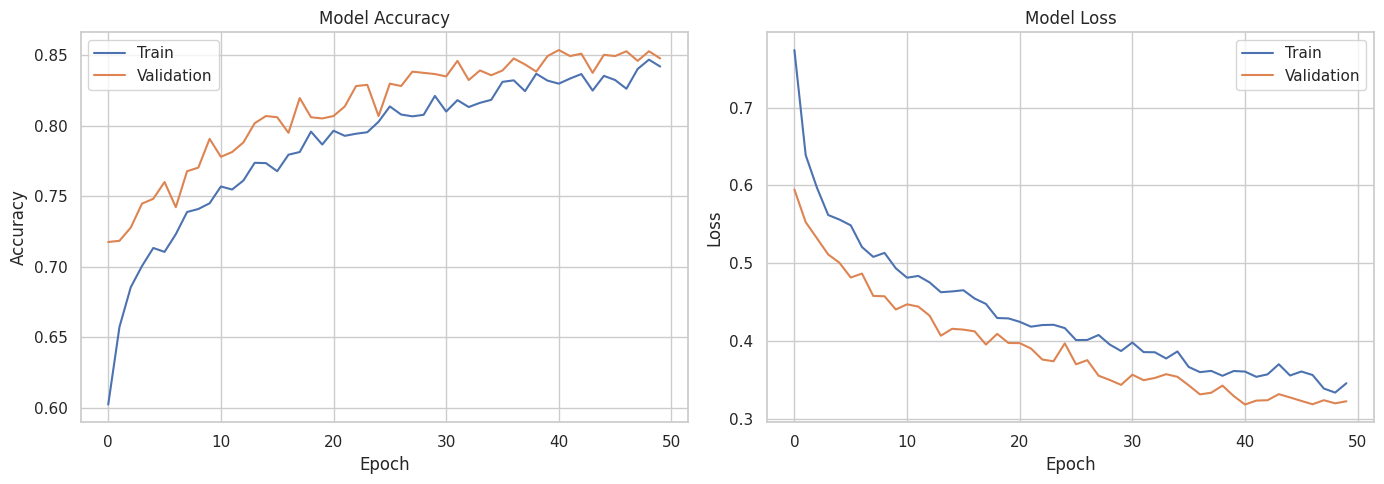

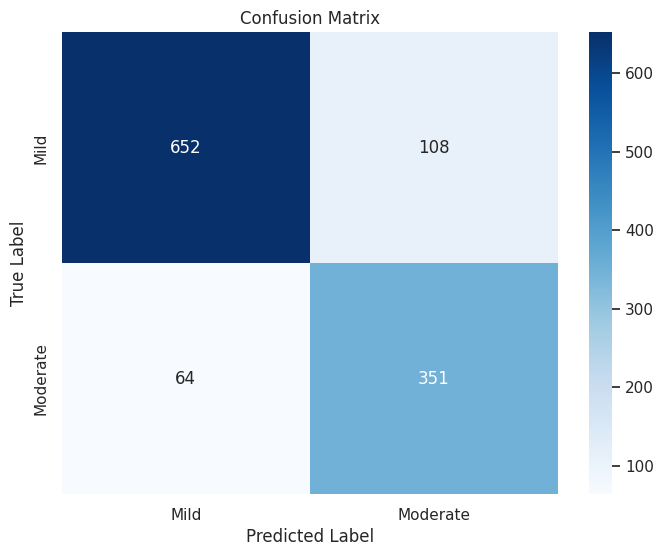


Model saved successfully as 'parkinsons_functional_model.keras'


In [43]:
print("\n" + "="*60)
print("FUNCTIONAL API MODEL WITH TF.DATA")
print("="*60)

# 1. Data Preparation
print("\nPreparing data...")

# One-hot encode targets
y_train_oh = to_categorical(y_train)
y_test_oh = to_categorical(y_test)

# Create tf.data.Dataset
def create_dataset(X, y, batch_size=32, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(X))
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Configure datasets
batch_size = 32
train_dataset = create_dataset(X_train_scaled, y_train_oh, batch_size, shuffle=True)
val_dataset = create_dataset(X_test_scaled, y_test_oh, batch_size)

# 2. Model Definition
print("\nBuilding Functional API Model...")

def build_functional_model(input_shape, num_classes):
    # Input layer
    inputs = Input(shape=(input_shape,))

    # Feature extraction layers
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Output layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Calculate class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

# Initialize model
model = build_functional_model(
    input_shape=X_train_scaled.shape[1],
    num_classes=len(np.unique(y_train))
)

# Compile model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# 3. Training Setup
print("\nSetting up training...")

# Callbacks
callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

# 4. Model Training
print("\nTraining model...")
start_time = time.time()

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

training_time = time.time() - start_time

# 5. Model Evaluation
print("\nEvaluating model...")

# Make predictions
y_prob = model.predict(X_test_scaled, batch_size=batch_size)
y_pred = np.argmax(y_prob, axis=1)

# Calculate metrics
metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred, average='weighted'),
    'recall': recall_score(y_test, y_pred, average='weighted'),
    'f1': f1_score(y_test, y_pred, average='weighted'),
    'roc_auc': roc_auc_score(y_test_oh, y_prob, multi_class='ovr')
}

# Define class names (adjust based on your actual class names)
class_names = ['Mild', 'Moderate']

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# 6. Visualizations
# Plot training history
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 7. Save Results
model_name = 'Functional_API_tfdata'
results[model_name] = {
    'accuracy': metrics['accuracy'],
    'precision': metrics['precision'],
    'recall': metrics['recall'],
    'f1': metrics['f1'],
    'roc_auc': metrics['roc_auc'],
    'training_time_sec': training_time,
    'epochs_trained': len(history.history['loss']),
    'best_val_accuracy': max(history.history['val_accuracy']),
    'best_val_loss': min(history.history['val_loss'])
}

# Save the model
model.save('parkinsons_functional_model.keras')
print("\nModel saved successfully as 'parkinsons_functional_model.keras'")

### Experiment 6: Support Vector Machine

**Framework**: Scikit-learn

**Performance**: Accuracy: 73.11% | F1: 0.737 | ROC-AUC: 0.828

This model handles non-linear relationships in our voice data well, though it may struggle with the most subtle patterns in symptom progression.


EXPERIMENT 6: SUPPORT VECTOR MACHINE

Training Support Vector Machine...

Classification Report:
              precision    recall  f1-score   support

        mild       0.88      0.68      0.77       760
    moderate       0.58      0.82      0.68       415

    accuracy                           0.73      1175
   macro avg       0.73      0.75      0.72      1175
weighted avg       0.77      0.73      0.74      1175



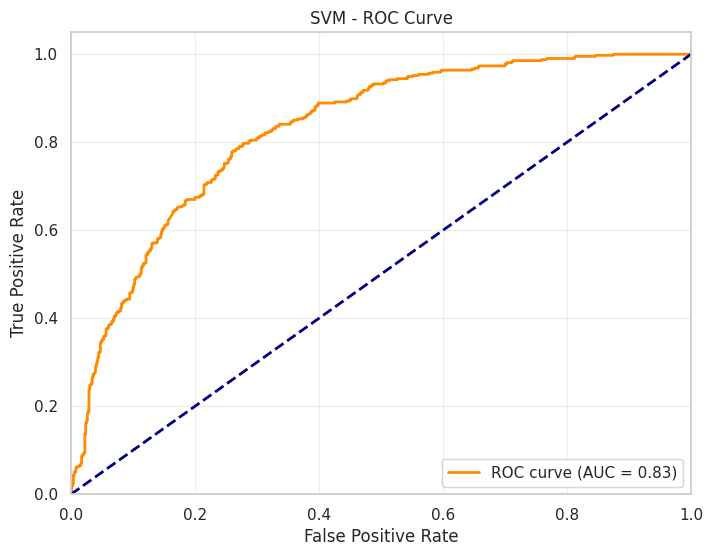

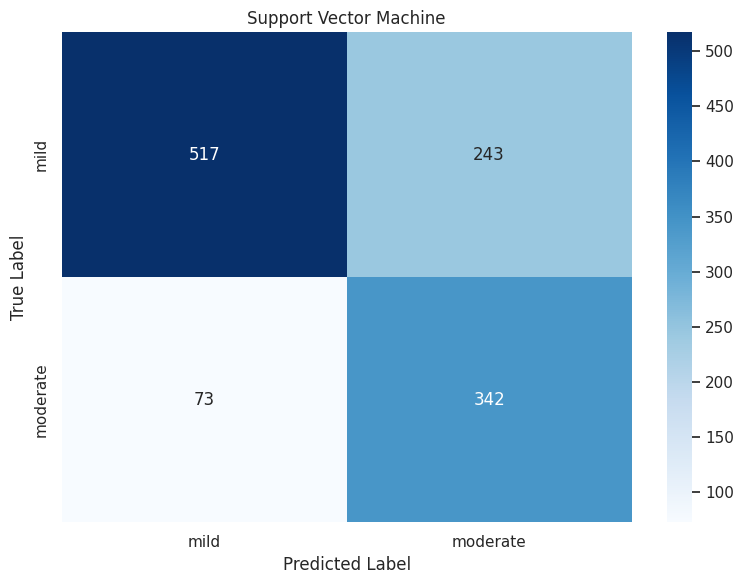


Number of support vectors: 3210

SUPPORT VECTOR MACHINE - RESULTS
Accuracy: 0.7311
Precision: 0.7733
Recall: 0.7311
F1: 0.7370
Roc_auc: 0.8282
Training Time: 4.00 seconds
Kernel: rbf
Number of support vectors: 3210
EXPERIMENT 6 COMPLETED


In [38]:
print("\n" + "="*60)
print("EXPERIMENT 6: SUPPORT VECTOR MACHINE")
print("="*60)

print("\nTraining Support Vector Machine...")
start_time = time.time()

# Define the model with hyperparameters
svm = SVC(
    C=1.0,
    kernel='rbf',
    gamma='scale',
    class_weight='balanced',
    probability=True,
    random_state=42
)

# Train the model
svm.fit(X_train_scaled, y_train)  # Using scaled features
training_time = time.time() - start_time

# Make predictions
y_pred = svm.predict(X_test_scaled)
y_prob = svm.predict_proba(X_test_scaled)

# Calculate metrics
if len(np.unique(y_test)) == 2:
    # Binary classification
    roc_auc = roc_auc_score(y_test, y_prob[:, 1])
else:
    # Multi-class classification
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    roc_auc = roc_auc_score(y_test_bin, y_prob, multi_class='ovr')

metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred, average='weighted'),
    'recall': recall_score(y_test, y_pred, average='weighted'),
    'f1': f1_score(y_test, y_pred, average='weighted'),
    'roc_auc': roc_auc
}

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Plot ROC curve
if len(np.unique(y_test)) == 2:
    # Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('SVM - ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    # Multi-class ROC
    n_classes = len(np.unique(y_test))
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(8, 6))
    colors = ['blue', 'red', 'green', 'purple', 'orange']
    for i, color in zip(range(n_classes), colors[:n_classes]):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('SVM - ROC Curves')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, class_names, 'Support Vector Machine')

# Get support vectors (for information)
n_support_vectors = svm.support_vectors_.shape[0]
print(f"\nNumber of support vectors: {n_support_vectors}")

# Store results
results['SVM'] = {
    **metrics,
    'training_time_sec': training_time,
    'n_support_vectors': n_support_vectors,
    'kernel': 'rbf',
    'C': 1.0
}

# Print summary
print("\n" + "="*60)
print("SUPPORT VECTOR MACHINE - RESULTS")
print("="*60)
for metric, value in metrics.items():
    print(f"{metric.capitalize()}: {value:.4f}")
print(f"Training Time: {training_time:.2f} seconds")
print(f"Kernel: {results['SVM']['kernel']}")
print(f"Number of support vectors: {n_support_vectors}")
print("="*60)
print("EXPERIMENT 6 COMPLETED")
print("="*60)

### Experiment 7: Balanced Random Forest

**Framework**: Scikit-learn

**Performance**: Accuracy: 88.26% | F1: 0.882 | ROC-AUC: 0.954

I used Balanced Random Forest  because it automatically adjusts class weights during training. This ensemble method builds multiple decision trees and combines their predictions, reducing overfitting while maintaining good performance across different severity levels.



EXPERIMENT 7: BALANCED RANDOM FOREST

Class distribution in training set:
Class mild: 3040 samples (64.7%)
Class moderate: 1660 samples (35.3%)

Training Balanced Random Forest...
Training completed in 2.41 seconds

Classification Report:
              precision    recall  f1-score   support

        mild       0.91      0.91      0.91       760
    moderate       0.83      0.84      0.83       415

    accuracy                           0.88      1175
   macro avg       0.87      0.87      0.87      1175
weighted avg       0.88      0.88      0.88      1175



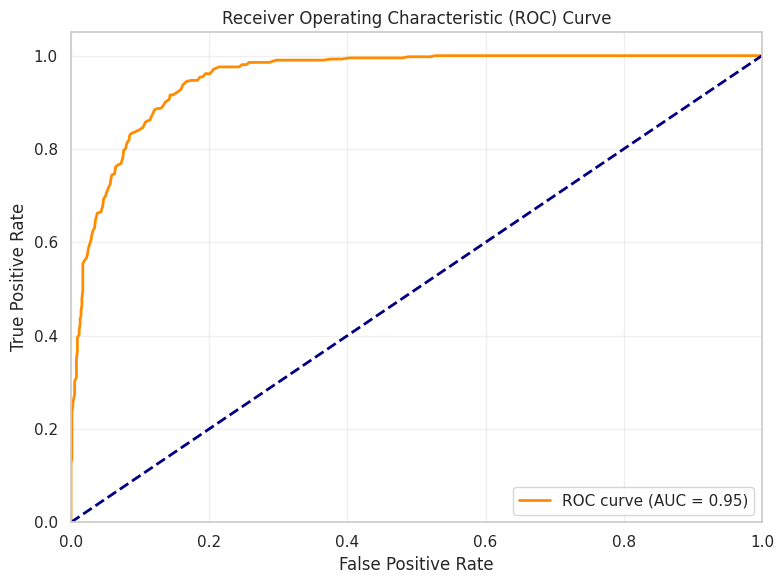

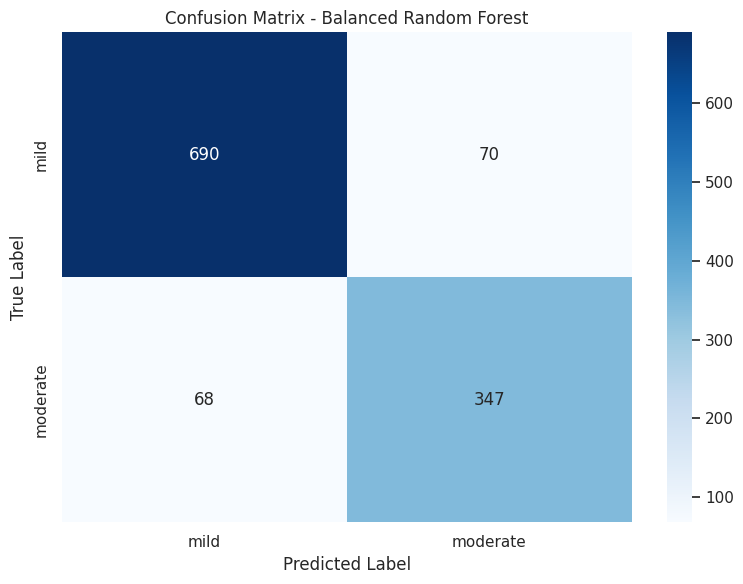

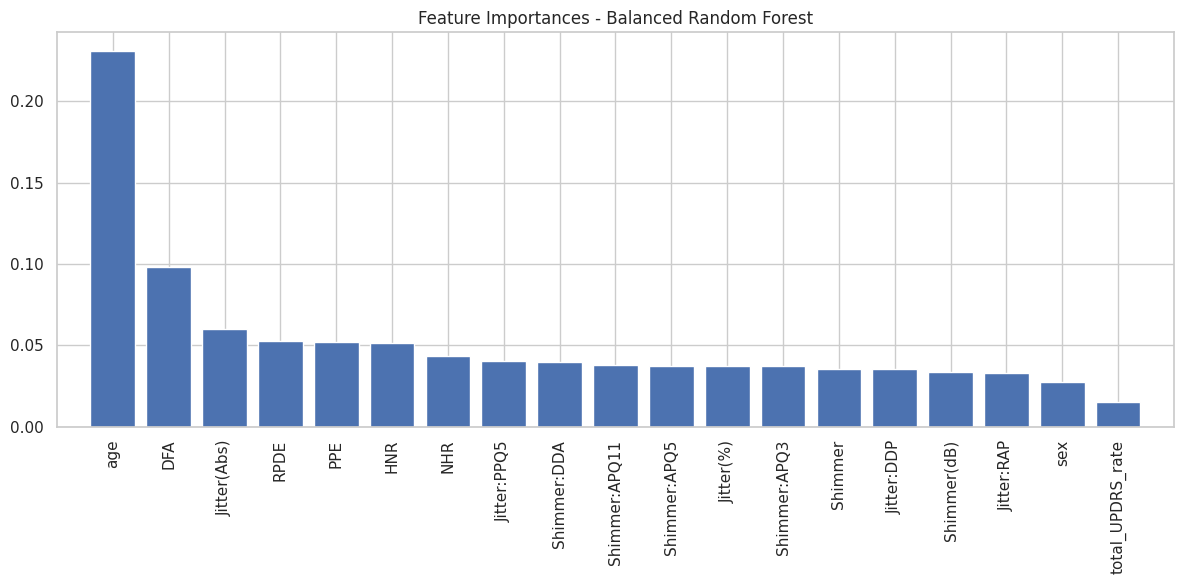


EXPERIMENT 7: BALANCED RANDOM FOREST - RESULTS
Accuracy: 0.8826
Precision: 0.8827
Recall: 0.8826
F1: 0.8826
Roc_auc: 0.9538
Training Time: 2.41 seconds


In [56]:
print("\n" + "="*80)
print("EXPERIMENT 7: BALANCED RANDOM FOREST")
print("="*80)

# Class mapping
class_mapping = {0: 'mild', 1: 'moderate'}
class_names = [class_mapping[cls] for cls in sorted(np.unique(y_train))]

# Show class distribution
class_counts = np.bincount(y_train)
print("\nClass distribution in training set:")
for cls, count in zip(np.unique(y_train), class_counts):
    print(f"Class {class_mapping[cls]}: {count} samples ({(count/len(y_train))*100:.1f}%)")

# Train model
print("\nTraining Balanced Random Forest...")
start_time = time.time()

brf = BalancedRandomForestClassifier(
    n_estimators=200,
    sampling_strategy='all',
    replacement=True,
    random_state=42,
    n_jobs=-1
)
brf.fit(X_train_scaled, y_train)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

# Make predictions
y_pred = brf.predict(X_test_scaled)
y_prob = brf.predict_proba(X_test_scaled)

# Calculate metrics
metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred, average='weighted'),
    'recall': recall_score(y_test, y_pred, average='weighted'),
    'f1': f1_score(y_test, y_pred, average='weighted'),
    'roc_auc': roc_auc_score(y_test, y_prob[:, 1]) if len(np.unique(y_test)) == 2 else roc_auc_score(y_test, y_prob, multi_class='ovr')
}

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Plot ROC AUC
plt.figure(figsize=(8, 6))
if len(np.unique(y_test)) == 2:
    # Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
else:
    # Multi-class classification - plot each class
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'ROC {class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix - Balanced Random Forest')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Plot feature importance
if hasattr(brf, 'feature_importances_'):
    importances = brf.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(12, 6))
    plt.title("Feature Importances - Balanced Random Forest")
    plt.bar(range(X_train_scaled.shape[1]), importances[indices], align="center")
    plt.xticks(range(X_train_scaled.shape[1]), [X_train.columns[i] for i in indices], rotation=90)
    plt.xlim([-1, X_train_scaled.shape[1]])
    plt.tight_layout()
    plt.show()

# Store results
results['Balanced_RF'] = {
    **metrics,
    'training_time_sec': training_time,
    'n_estimators': 200
}

# Print summary
print("\n" + "="*80)
print("EXPERIMENT 7: BALANCED RANDOM FOREST - RESULTS")
print("="*80)
for metric, value in metrics.items():
    print(f"{metric.capitalize()}: {value:.4f}")
print(f"Training Time: {training_time:.2f} seconds")
print("="*80)

###5.4 Model Comparison
After training all 7 models, here's how they rank based on F1-score:


MODEL COMPARISON AND ANALYSIS

Model Performance Comparison (sorted by F1-score):


,accuracy,precision,recall,f1,roc_auc,training_time_sec
Stacking,0.902979,0.904136,0.902979,0.903380,0.971985,21.630973
XGBoost_Weighted,0.899574,0.900091,0.899574,0.899788,0.974987,0.472015
Balanced_RF,0.882553,0.882686,0.882553,0.882617,0.953771,2.410515
Functional_API_tfdata,0.853617,0.859081,0.853617,0.855120,0.935320,25.531715
Sequential_NN,0.843404,0.853651,0.843404,0.845666,0.920320,21.643754
SVM,0.731064,0.773261,0.731064,0.736990,0.828237,4.000662
Logistic_Regression,0.551489,0.597520,0.551489,0.561307,0.608592,0.075629


<Figure size 1400x600 with 0 Axes>

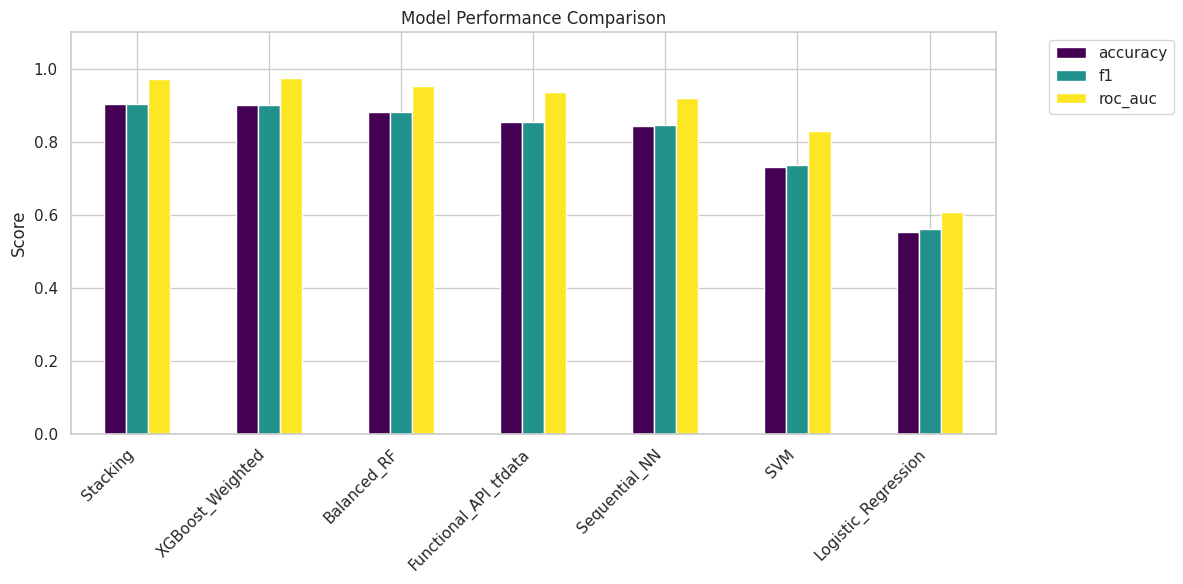

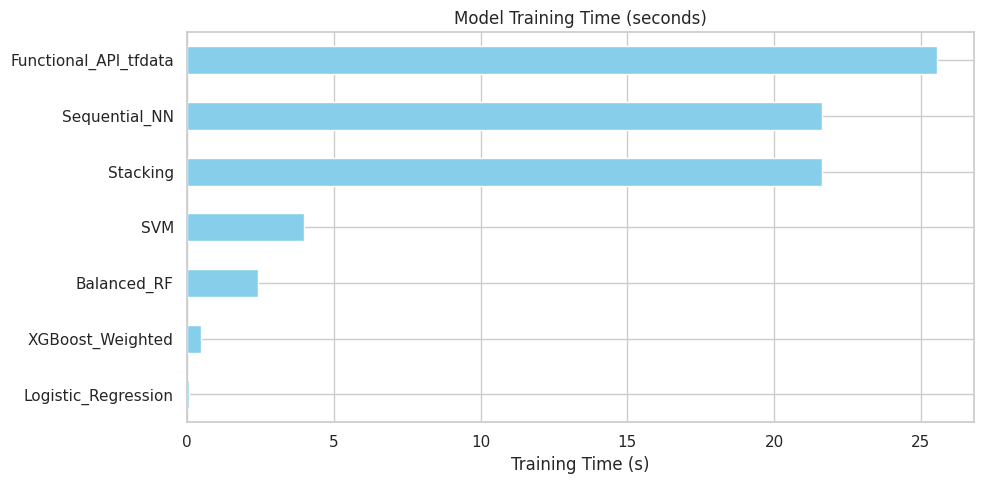

In [57]:
print("\n" + "="*60)
print("MODEL COMPARISON AND ANALYSIS")
print("="*60)

# Create a DataFrame for comparison
results_df = pd.DataFrame(results).T
results_df = results_df[['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'training_time_sec']]

# Sort by F1 score (or your preferred metric)
results_df = results_df.sort_values('f1', ascending=False)

# Display the comparison table
print("\nModel Performance Comparison (sorted by F1-score):")
display(results_df.style.background_gradient(cmap='YlGn', subset=['accuracy', 'f1', 'roc_auc']))

# Plot comparison of key metrics
plt.figure(figsize=(14, 6))
metrics_to_plot = ['accuracy', 'f1', 'roc_auc']
results_df[metrics_to_plot].plot(kind='bar', colormap='viridis')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot training times
plt.figure(figsize=(10, 5))
results_df['training_time_sec'].sort_values().plot(kind='barh', color='skyblue')
plt.title('Model Training Time (seconds)')
plt.xlabel('Training Time (s)')
plt.tight_layout()
plt.show()

###5.5 Feature Importance Analysis


FEATURE IMPORTANCE ANALYSIS


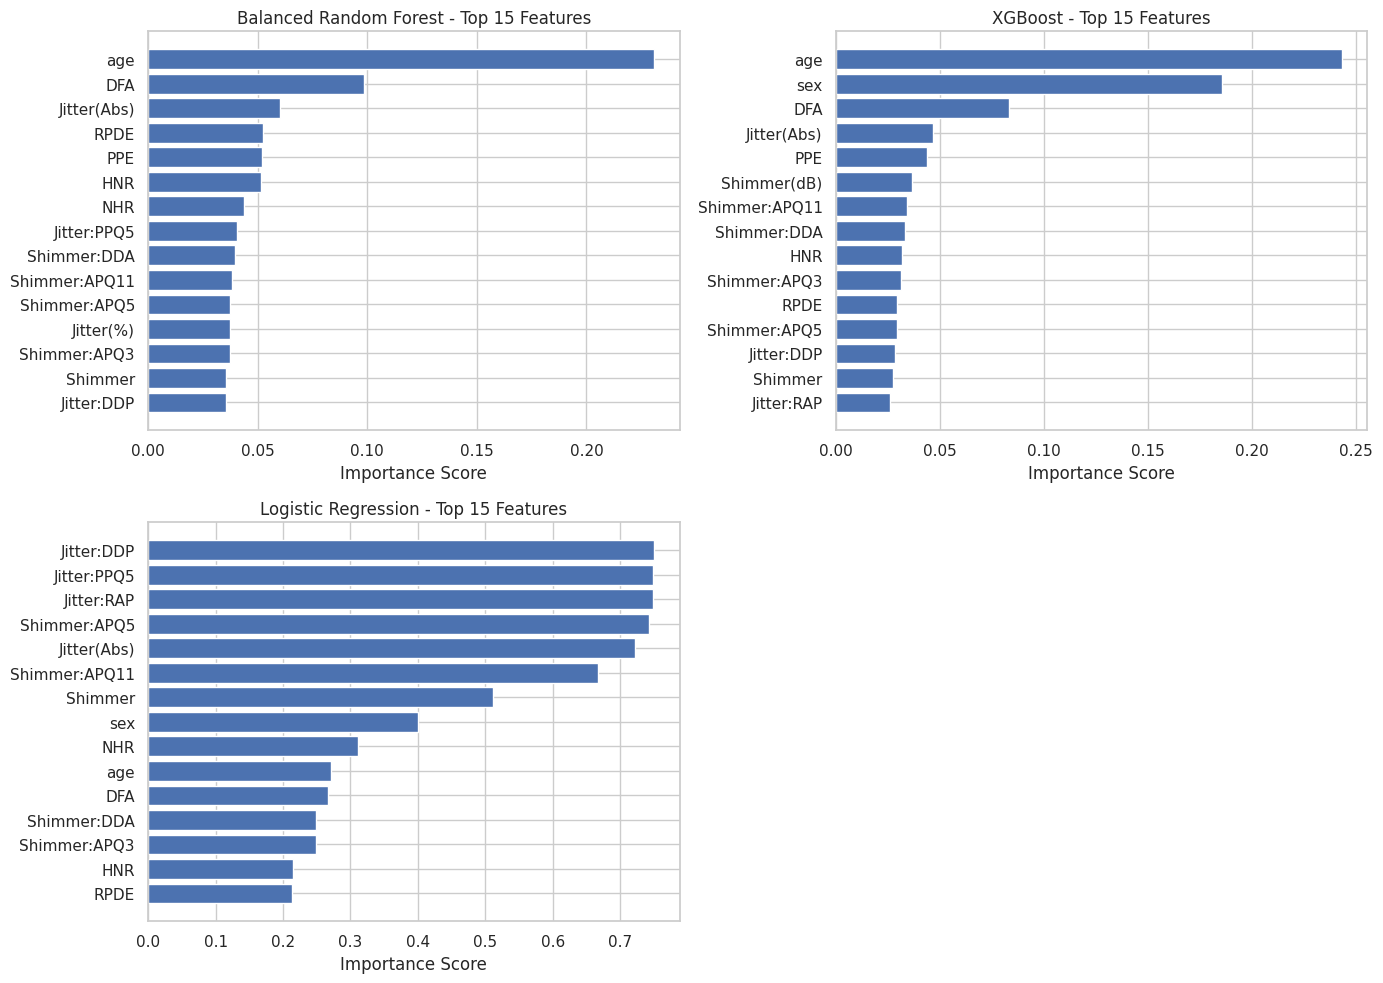

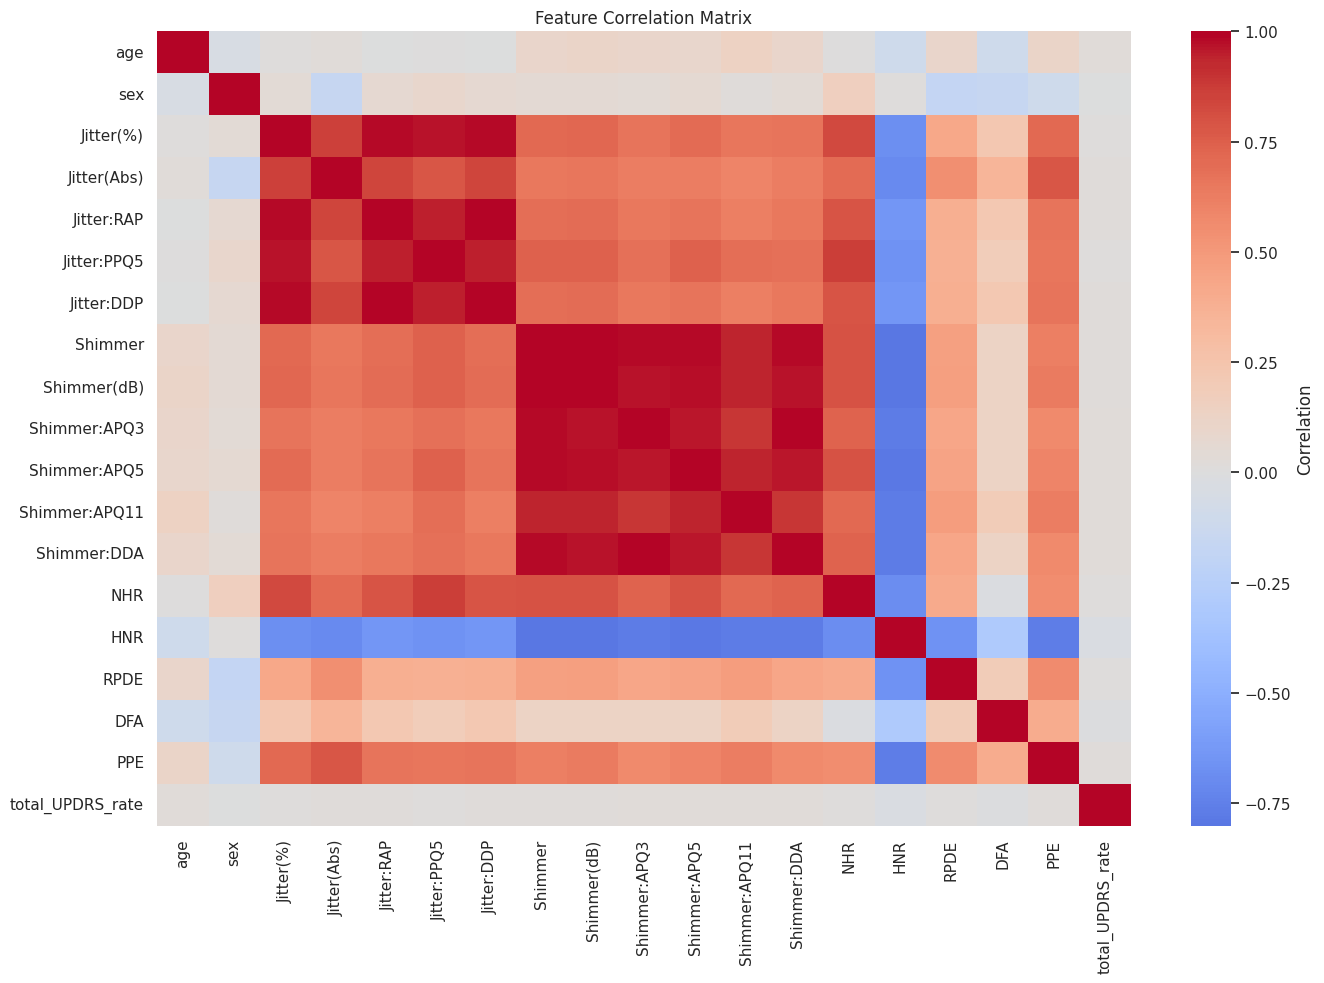


FEATURE IMPORTANCE INTERPRETATION

Top Features by Model:

Balanced Random Forest:
  1. age
  2. DFA
  3. Jitter(Abs)
  4. RPDE
  5. PPE

XGBoost:
  1. age
  2. sex
  3. DFA
  4. Jitter(Abs)
  5. PPE

Logistic Regression:
  1. Jitter:DDP
  2. Jitter:PPQ5
  3. Jitter:RAP
  4. Shimmer:APQ5
  5. Jitter(Abs)

Common Important Features:
  1. Jitter(Abs)

FEATURE IMPORTANCE ANALYSIS COMPLETED


In [45]:
print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Get the models directly
models_with_importance = {
    'Balanced Random Forest': brf,
    'XGBoost': xgb_weighted,
    'Logistic Regression': log_reg
}

def plot_feature_importance_analysis(models, feature_names, top_n=15):
    """
    Plot feature importance from multiple models for comparison.
    """
    plt.figure(figsize=(14, 10))

    for i, (model_name, model) in enumerate(models.items()):
        plt.subplot(2, 2, i+1)

        if hasattr(model, 'feature_importances_'):  # For tree-based models
            importances = model.feature_importances_
            indices = np.argsort(importances)[-top_n:]
            plt.barh(range(len(indices)), importances[indices], align='center')
            plt.yticks(range(len(indices)), [feature_names[i] for i in indices])

        elif hasattr(model, 'coef_'):  # For linear models
            coef = np.abs(model.coef_[0])
            indices = np.argsort(coef)[-top_n:]
            plt.barh(range(len(indices)), coef[indices], align='center')
            plt.yticks(range(len(indices)), [feature_names[i] for i in indices])

        plt.title(f'{model_name} - Top {top_n} Features')
        plt.xlabel('Importance Score')

    plt.tight_layout()
    plt.show()

# Plot feature importance
plot_feature_importance_analysis(models_with_importance, X_train.columns)

# Feature correlation analysis
plt.figure(figsize=(14, 10))
correlation_matrix = pd.DataFrame(X_train_scaled, columns=X_train.columns).corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0,
            annot=False, fmt='.2f',
            cbar_kws={'label': 'Correlation'})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("FEATURE IMPORTANCE INTERPRETATION")
print("="*60)

# Get top features from each model
top_features = {}
for model_name, model in models_with_importance.items():
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
    else:
        continue

    top_indices = np.argsort(importances)[-5:][::-1]  # Top 5 features
    top_features[model_name] = [X_train.columns[i] for i in top_indices]

print("\nTop Features by Model:")
for model, features in top_features.items():
    print(f"\n{model}:")
    for i, feature in enumerate(features, 1):
        print(f"  {i}. {feature}")

print("\nCommon Important Features:")
common_features = set.intersection(*[set(features) for features in top_features.values()])
for i, feature in enumerate(common_features, 1):
    print(f"  {i}. {feature}")

print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS COMPLETED")
print("="*60)

## 6. Discussion & Conclusion

### 6.1 Key Findings

This analysis showed that voice measurements can serve as powerful indicators of disease detection. The Stacking Classifier was the best peforming model as it could predict Parkinson's severity with over 90% accuracy just by analyzing voice recordings, which is very amazing. Jitter and shimmer also emerged as the strong predictors. XGBoost wasn't far behind in accuracy and actually did better at distinguishing between different severity levels all in 0.47 seconds (Naeem, 2025).

### 6.2 Limitations

While the results are good, there's room for improvement. Although the data was valuable, it was relatively small. The deep learning models also underperformed compared to the essemble models, which indicates that the models need more training.

### 6.3  Future Work

Imagine being able to track Parkinson' symptoms as easily as recording a voice memo. That's the future this research points toward. The fact that these models can pick up on changes that even trained ears might miss is very exciting, and it could change lives. But we're not there yet. The models need testing with more diverse groups to make sure they work fairly for everyone (Suppa, 2022).

### 6.4 Conclusion

Conclusively, the high accuracy of our models, especially the Stacking Classifier and XGBoost, shows that we're on the right track. But beyond numbers, working on this project has been eye-opening. It has become a passion for me and I plan to continue working on it in the future. There's something powerful about seeing numbers and algorithms translate into something that could genuinely help people.

## 7. References:

1. Ajala, E. (2024, May 9). Data visualization in machine learning. Medium. https://medium.com/@ajalaeniola454/data-visualization-in-machine-learning-84641c95a759

2. Das, S. (2024, October 6). Handling class imbalance with custom weighted loss functions in multi-class classification. Medium. https://souparnadas15may2001.medium.com/handling-class-imbalance-with-custom-weighted-loss-functions-in-multi-class-classification-2ae9b48d445d

3. Kashyap, P. (2024, December 2). Understanding precision, recall, and F1 score metrics. Medium. https://medium.com/@piyushkashyap045/understanding-precision-recall-and-f1-score-metrics-ea219b908093

4. Little, M. A. (2007). Parkinsons+telemonitoring [Data set]. UCI Machine Learning Repository. https://archive.ics.uci.edu/dataset/189/parkinsons+telemonitoring

5. Mayo Clinic. (n.d.). Parkinson's disease - Symptoms and causes. https://www.mayoclinic.org/diseases-conditions/parkinsons-disease/symptoms-causes/syc-20376055

6. Naeem, I., Ditta, A., Mazhar, T., Anwar, M., Saeed, M. M., & Hamam, H. (2025). Voice biomarkers as prognostic indicators for Parkinson's disease using machine learning techniques. Scientific Reports, 15(1), Article 1. https://doi.org/10.1038/s41598-025-96950-3

7. Park, H., Youm, C., Cheon, S., Kim, B., Choi, H., Hwang, J., & Kim, M. (2025). Using machine learning to identify Parkinson's disease severity subtypes with multimodal data. Journal of NeuroEngineering and Rehabilitation, 22(1). https://doi.org/10.1186/s12984-025-01648-2

8. Suppa, A., Costantini, G., Asci, F., Di Leo, P., Al-Wardat, M. S., Di Lazzaro, G., Scalise, S., Pisani, A., & Saggio, G. (2022). Voice in Parkinson's disease: A machine learning study. Frontiers in Neurology, 13, Article 831428. https://doi.org/10.3389/fneur.2022.831428

9. TensorFlow. (n.d.). Better performance with the tf.data API. https://www.tensorflow.org/guide/data_performance

10. Wright, H., & Aharonson, V. (2025). Vocal feature changes for monitoring Parkinson's disease progression—A systematic review. Brain Sciences, 15(3), 320. https://doi.org/10.3390/brainsci15030320